# Course project - Database Management MAP543
***
In the following, we explore an efficient and scalable approach in MapReduce to find all the connected components in a given graph. Finding connected components in a graph is a well-known problem in a wide variety of application areas such as social network analysis, data mining, image processing ...

•The algorithm is descibed in this [paper](https://www.cse.unr.edu/~hkardes/pdfs/ccf.pdf)

•The work to consists of understanding the MapReduce algorithm, and coding it into Spark by using both RDD and DataFrames 

•Both Python and Scala implementations must be provided,  

•Experimental analysis comparing the RDD and DataFrame versions has to be conducted on graphs of increasing size 

•For small graphs use Databricks, for bigger ones (<20GB) use the GC cluster.


A graph is a mathematical structure used to model relationships between objects. It consists of a set of nodes and a set of edges that connect pairs of nodes.

A graph is said to be connected if for every pair of vertices in a graph, there exists a sequence of edges that forms a path between those vertices.

We chose to use the [Web Google graph](http://snap.stanford.edu/data/web-Google.html) released in 2002 by Google. There are 875K nodes and 5.1M edges in this graph. Nodes represent web pages and directed edges represent hyperlinks between them.


[LiveJournal](https://snap.stanford.edu/data/soc-LiveJournal1.html) is a free on-line community with almost 10 million members; a significant fraction of these members are highly active. (For example, roughly 300,000 update their content in any given 24-hour period.) LiveJournal allows members to maintain journals, individual and group blogs, and it allows people to declare which other members are their friends they belong. It has 484k nodes and 68.9M edges.

In [49]:
import os
from pyspark import SparkContext, SparkConf
from pyspark.rdd import RDD
import time
from typing import Tuple

# Set the absolute path to your JDK installation
os.environ['JAVA_HOME'] = '/Library/Java/JavaVirtualMachines/jdk-22.jdk/Contents/Home'

# Configure and initialize Spark
conf = SparkConf().setAppName("Connected_Components").setMaster("local")
sc = SparkContext(conf=conf)

# Import Data

In [50]:
file_path = "/Users/gaspardhassenforder/Documents/X/Database Management/Project_Connected_graphs/web-Google.txt.gz"
data_google = sc.textFile(file_path)

file_path = "/Users/gaspardhassenforder/Documents/X/Database Management/Project_Connected_graphs/soc-LiveJournal1.txt.gz"
data_livejournal = sc.textFile(file_path)

# clean the data, since from same source they have the same format
def clean_google(x: str) -> Tuple[int, int]:
    if "#" in x:
        return None
    else:
        return tuple(map(int, x.split("\t")))
    
data_google = data_google.map(clean_google).filter(lambda x: x is not None)
data_livejournal = data_livejournal.map(clean_google).filter(lambda x: x is not None)



# Techniques from paper

## CCF-Iterate

In [51]:

########## Correct
from pyspark import RDD

def ccf_iterate(rdd: RDD) -> Tuple[RDD, int]:
    # Inverting the RDD pairs and merging with the original RDD
    inverted_rdd = rdd.map(lambda pair: (pair[1], pair[0]))
    full_graph = rdd.union(inverted_rdd).groupByKey().mapValues(list).partitionBy(100).cache()

    # Processing the graph: converting to integers, extracting min, and filtering
    processed_graph = (
        full_graph
        .map(lambda node: (int(node[0]), list(map(int, node[1]))))  # Ensure all are integers
        .map(lambda node: (node[0], node[1], min(node[1])))  # Attach minimum value from list
        .filter(lambda node: node[0] > node[2])  # Condition to filter nodes
        .map(lambda node: (node[0], [value for value in node[1] if value != node[2]], node[2]))  # Remove min value from list
    )

    # Summing the lengths of the modified lists to count new pairs
    total_new_pairs = processed_graph.map(lambda node: len(node[1])).sum()

    # Emitting pairs for final output and deduplication
    initial_emit = processed_graph.map(lambda node: (node[0], node[2]))
    expanded_emit = processed_graph.flatMap(lambda node: [(value, node[2]) for value in node[1]])
    all_emits = initial_emit.union(expanded_emit)

    # Final deduplication and preparation of output
    unique_pairs = (
        all_emits
        .map(lambda pair: ((pair[0], pair[1]), None))
        .reduceByKey(lambda x, _: x)  # Using _ for unused variable in lambda
        .map(lambda pair: pair[0])
    )

    return unique_pairs, total_new_pairs



## CCF- Iterate with secondary sorting

In [52]:


def ccf_iterate_sorting(rdd: RDD) -> Tuple[RDD, int]:
    # Invert and merge to form a graph, then organize by key
    inverted_rdd = rdd.map(lambda pair: (pair[1], pair[0]))
    combined_graph = rdd.union(inverted_rdd).groupByKey().mapValues(list).partitionBy(100).cache()

    # Clean and prepare the graph
    prepared_graph = (
        combined_graph
        .map(lambda node: (int(node[0]), sorted(set(map(int, node[1])))))  # Ensure uniqueness and sort
        .map(lambda node: (node[0], node[1], node[1][0]))  # Attach min value
        .filter(lambda node: node[0] > node[2])  # Filter based on condition
        .map(lambda node: (node[0], node[1][1:], node[2]))  # Update list by removing min
    )

    # Calculate the new pairs and prepare for further actions
    count_new_pairs = prepared_graph.map(lambda node: len(node[1])).sum()
    first_emit = prepared_graph.map(lambda node: (node[0], node[2]))
    second_emit = prepared_graph.flatMap(lambda node: [(value, node[2]) for value in node[1]])
    total_emission = first_emit.union(second_emit)

    # Deduplicate pairs
    deduplicated_pairs = (
        total_emission
        .map(lambda pair: ((pair[0], pair[1]), None))
        .reduceByKey(lambda x, y: x)
        .map(lambda pair: (pair[0][0], pair[0][1]))
    )

    return deduplicated_pairs, count_new_pairs


# Apply techniques

In [53]:
def find_connected_components(graph, method):
    start_time = time.time()
    new_pairs = 1
    iter = 0
    while new_pairs != 0:
        print(method.__name__)
        
        try:
            graph, new_pairs = method(graph)
        except Exception as e:
            print("Method not found or failed with error:", e)
            break
            
        print("Iteration: ", iter, " - New pairs: ", new_pairs)
        
        iter += 1
        
    n_components = graph.map(lambda x : x[1]).distinct().count()
    end_time = time.time()
    return graph, iter - 1, n_components, end_time - start_time

In [54]:
# Initialize an empty dictionary
results = {}
methods = [ccf_iterate, ccf_iterate_sorting]


In [55]:
# For google data

for method in methods:
    result_google, num_iter, n_components, time_taken = find_connected_components(data_google, method)
    results["Google"] = [time_taken, num_iter, method]
    print(f"{method.__name__} took {time_taken} seconds and {num_iter} iterations to complete, and found {n_components} components in graph:")



ccf_iterate_sorting


Iteration:  0  - New pairs:  7223780
ccf_iterate_sorting


Iteration:  1  - New pairs:  4758451
ccf_iterate_sorting


Iteration:  2  - New pairs:  3278772
ccf_iterate_sorting


Iteration:  3  - New pairs:  3888454
ccf_iterate_sorting


Iteration:  4  - New pairs:  1905323
ccf_iterate_sorting


Iteration:  5  - New pairs:  86783
ccf_iterate_sorting


Iteration:  6  - New pairs:  1318
ccf_iterate_sorting


Iteration:  7  - New pairs:  0


ccf_iterate_sorting took 458.6533269882202 seconds and 7 iterations to complete, and found 2746 components in graph:


In [11]:
# For Livejournal data

for method in methods:
    result_livejournal, num_iter, n_components, time_taken = find_connected_components(data_livejournal, method)
    results["Livejournal"] = [time_taken, num_iter, method]
    print(f"{method.__name__} took {time_taken} seconds and {num_iter} iterations to complete, and found {n_components} components in graph:")



optimized_ccf_iterate


24/04/10 17:20:09 WARN MemoryStore: Not enough space to cache rdd_318_96 in memory! (computed 1106.6 KiB so far)
24/04/10 17:20:09 WARN BlockManager: Block rdd_318_96 could not be removed as it was not found on disk or in memory
24/04/10 17:20:09 WARN BlockManager: Putting block rdd_318_96 failed
24/04/10 17:20:09 WARN MemoryStore: Not enough space to cache rdd_318_97 in memory! (computed 1038.7 KiB so far)
24/04/10 17:20:09 WARN BlockManager: Block rdd_318_97 could not be removed as it was not found on disk or in memory
24/04/10 17:20:09 WARN BlockManager: Putting block rdd_318_97 failed
24/04/10 17:20:09 WARN MemoryStore: Not enough space to cache rdd_318_98 in memory! (computed 1116.4 KiB so far)
24/04/10 17:20:09 WARN BlockManager: Block rdd_318_98 could not be removed as it was not found on disk or in memory
24/04/10 17:20:09 WARN BlockManager: Putting block rdd_318_98 failed
24/04/10 17:20:10 WARN MemoryStore: Not enough space to cache rdd_318_99 in memory! (computed 1057.4 KiB s

Iteration:  0  - New pairs:  130613477
optimized_ccf_iterate


24/04/10 17:23:01 WARN MemoryStore: Not enough space to cache rdd_318_96 in memory! (computed 1106.6 KiB so far)
24/04/10 17:23:01 WARN BlockManager: Block rdd_318_96 could not be removed as it was not found on disk or in memory
24/04/10 17:23:01 WARN BlockManager: Putting block rdd_318_96 failed
24/04/10 17:23:01 WARN MemoryStore: Not enough space to cache rdd_318_97 in memory! (computed 1038.7 KiB so far)
24/04/10 17:23:01 WARN BlockManager: Block rdd_318_97 could not be removed as it was not found on disk or in memory
24/04/10 17:23:01 WARN BlockManager: Putting block rdd_318_97 failed
24/04/10 17:23:01 WARN MemoryStore: Not enough space to cache rdd_318_98 in memory! (computed 1116.4 KiB so far)
24/04/10 17:23:01 WARN BlockManager: Block rdd_318_98 could not be removed as it was not found on disk or in memory
24/04/10 17:23:01 WARN BlockManager: Putting block rdd_318_98 failed
24/04/10 17:23:01 WARN MemoryStore: Not enough space to cache rdd_318_99 in memory! (computed 1057.4 KiB s

Iteration:  1  - New pairs:  109741265
optimized_ccf_iterate


24/04/10 17:30:14 WARN MemoryStore: Not enough space to cache rdd_337_90 in memory! (computed 3.9 MiB so far)
24/04/10 17:30:14 WARN BlockManager: Block rdd_337_90 could not be removed as it was not found on disk or in memory
24/04/10 17:30:14 WARN BlockManager: Putting block rdd_337_90 failed
24/04/10 17:30:14 WARN MemoryStore: Not enough space to cache rdd_337_91 in memory! (computed 3.8 MiB so far)
24/04/10 17:30:14 WARN BlockManager: Block rdd_337_91 could not be removed as it was not found on disk or in memory
24/04/10 17:30:14 WARN BlockManager: Putting block rdd_337_91 failed
24/04/10 17:30:15 WARN MemoryStore: Not enough space to cache rdd_337_92 in memory! (computed 3.9 MiB so far)
24/04/10 17:30:15 WARN BlockManager: Block rdd_337_92 could not be removed as it was not found on disk or in memory
24/04/10 17:30:15 WARN BlockManager: Putting block rdd_337_92 failed
24/04/10 17:30:15 WARN MemoryStore: Not enough space to cache rdd_337_93 in memory! (computed 3.8 MiB so far)
24/04

Iteration:  2  - New pairs:  95032863
optimized_ccf_iterate


Iteration:  3  - New pairs:  9334607
optimized_ccf_iterate


Iteration:  4  - New pairs:  16906
optimized_ccf_iterate


Iteration:  5  - New pairs:  44
optimized_ccf_iterate


Iteration:  6  - New pairs:  0


optimized_ccf_iterate took 1585.754937171936 seconds and 6 iterations to complete, and found 914 components in graph:
ccf_iterate_sorting


24/04/10 17:47:09 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_455_96 in memory.
24/04/10 17:47:09 WARN MemoryStore: Not enough space to cache rdd_455_96 in memory! (computed 0.0 B so far)
24/04/10 17:47:09 WARN BlockManager: Block rdd_455_96 could not be removed as it was not found on disk or in memory
24/04/10 17:47:09 WARN BlockManager: Putting block rdd_455_96 failed
24/04/10 17:47:09 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_455_97 in memory.
24/04/10 17:47:09 WARN MemoryStore: Not enough space to cache rdd_455_97 in memory! (computed 0.0 B so far)
24/04/10 17:47:09 WARN BlockManager: Block rdd_455_97 could not be removed as it was not found on disk or in memory
24/04/10 17:47:09 WARN BlockManager: Putting block rdd_455_97 failed
24/04/10 17:47:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_455_98 in memory.
24/04/10 

Iteration:  0  - New pairs:  81353582
ccf_iterate_sorting


24/04/10 17:47:38 WARN MemoryStore: Not enough space to cache rdd_455_0 in memory! (computed 3.9 MiB so far)
24/04/10 17:47:38 WARN BlockManager: Block rdd_455_0 could not be removed as it was not found on disk or in memory
24/04/10 17:47:38 WARN BlockManager: Putting block rdd_455_0 failed
24/04/10 17:53:12 WARN MemoryStore: Not enough space to cache rdd_455_96 in memory! (computed 3.8 MiB so far)
24/04/10 17:53:12 WARN BlockManager: Block rdd_455_96 could not be removed as it was not found on disk or in memory
24/04/10 17:53:12 WARN BlockManager: Putting block rdd_455_96 failed
24/04/10 17:53:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_455_98 in memory.
24/04/10 17:53:13 WARN MemoryStore: Not enough space to cache rdd_455_98 in memory! (computed 0.0 B so far)
24/04/10 17:53:13 WARN BlockManager: Block rdd_455_98 could not be removed as it was not found on disk or in memory
24/04/10 17:53:13 WARN BlockManager: Putting block rdd

Iteration:  1  - New pairs:  109741265
ccf_iterate_sorting


24/04/10 18:01:42 WARN MemoryStore: Not enough space to cache rdd_474_90 in memory! (computed 3.9 MiB so far)
24/04/10 18:01:42 WARN BlockManager: Block rdd_474_90 could not be removed as it was not found on disk or in memory
24/04/10 18:01:42 WARN BlockManager: Putting block rdd_474_90 failed
24/04/10 18:01:42 WARN MemoryStore: Not enough space to cache rdd_474_91 in memory! (computed 3.8 MiB so far)
24/04/10 18:01:42 WARN BlockManager: Block rdd_474_91 could not be removed as it was not found on disk or in memory
24/04/10 18:01:42 WARN BlockManager: Putting block rdd_474_91 failed
24/04/10 18:01:43 WARN MemoryStore: Not enough space to cache rdd_474_92 in memory! (computed 3.9 MiB so far)
24/04/10 18:01:43 WARN BlockManager: Block rdd_474_92 could not be removed as it was not found on disk or in memory
24/04/10 18:01:43 WARN BlockManager: Putting block rdd_474_92 failed
24/04/10 18:01:43 WARN MemoryStore: Not enough space to cache rdd_474_93 in memory! (computed 3.8 MiB so far)
24/04

Iteration:  2  - New pairs:  95032863
ccf_iterate_sorting


Iteration:  3  - New pairs:  9334607
ccf_iterate_sorting


Iteration:  4  - New pairs:  16906
ccf_iterate_sorting


Iteration:  5  - New pairs:  44
ccf_iterate_sorting


Iteration:  6  - New pairs:  0


ccf_iterate_sorting took 1961.048485994339 seconds and 6 iterations to complete, and found 914 components in graph:


In [13]:
# get number of nodes in largest connected component
largest_component = result.groupBy(lambda x : x[1]).map(lambda x : len(x[1])).max()

In [15]:
print("Number of nodes in largest connected component: ", largest_component)

Number of nodes in largest connected component:  4843952


# Plot

google with normal cff : 468.4991731643677 seconds 
google with cff with secondary sorting : 517.3975059986115, 
7 iterations, 2746 components


livejournal with normal cff: 1585.754937171936
google with cff with secondary sorting :1961.048485994339 ,  
6 iterations, 914 components 

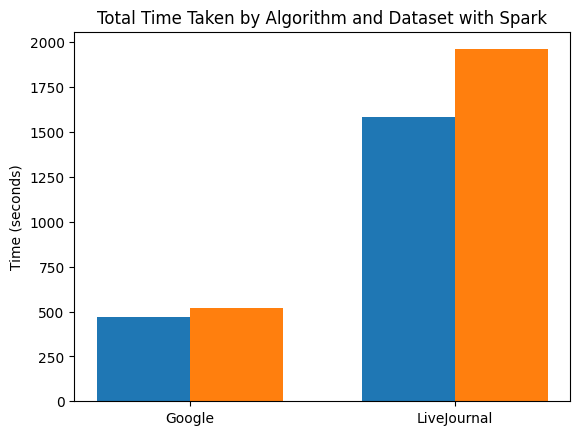

In [42]:

import matplotlib.pyplot as plt
import numpy as np

# Manually input the Scala variables here
iterations_data = {'Google': 7, 'LiveJournal': 6, 'GoogleSecondarySort':7, 'LiveJournalSecondarySort': 6}
time_data = {'Google': 468.4991731643677, 'LiveJournal': 1585.754937171936, 'GoogleSecondarySort': 517.3975059986115, 'LiveJournalSecondarySort': 1961.048485994339}



labels = ['Google', 'LiveJournal']
iterations = [iterations_data['Google'], iterations_data['LiveJournal']]
iterations_improved = [iterations_data['GoogleSecondarySort'], iterations_data['LiveJournalSecondarySort']]
times = [time_data['Google'], time_data['LiveJournal']]
times_improved = [time_data['GoogleSecondarySort'], time_data['LiveJournalSecondarySort']]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars





# Time
plt.bar(x - width/2, times, width, label='CCF Iterate')
plt.bar(x + width/2, times_improved, width, label='CF Iterate with second sorting')
plt.ylabel('Time (seconds)')
plt.title('Total Time Taken by Algorithm and Dataset with Spark')
plt.xticks(x, labels) 

fig.tight_layout()
plt.show()


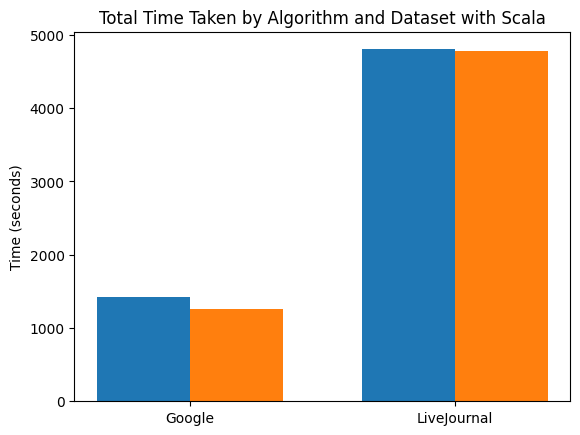

In [41]:

import matplotlib.pyplot as plt
import numpy as np

# Manually input the Scala variables here
iterations_data = {'Google': 7, 'LiveJournal': 6, 'GoogleSecondarySort':7, 'LiveJournalSecondarySort': 6}
time_data = {'Google': 1418.51, 'LiveJournal': 4803.03, 'GoogleSecondarySort': 1255.89, 'LiveJournalSecondarySort': 4782.92}


labels = ['Google', 'LiveJournal']
iterations = [iterations_data['Google'], iterations_data['LiveJournal']]
iterations_improved = [iterations_data['GoogleSecondarySort'], iterations_data['LiveJournalSecondarySort']]
times = [time_data['Google'], time_data['LiveJournal']]
times_improved = [time_data['GoogleSecondarySort'], time_data['LiveJournalSecondarySort']]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars





# Time
plt.bar(x - width/2, times, width, label='CCF Iterate')
plt.bar(x + width/2, times_improved, width, label='CF Iterate with second sorting')
plt.ylabel('Time (seconds)')
plt.title('Total Time Taken by Algorithm and Dataset with Scala')
plt.xticks(x, labels) 

fig.tight_layout()
plt.show()


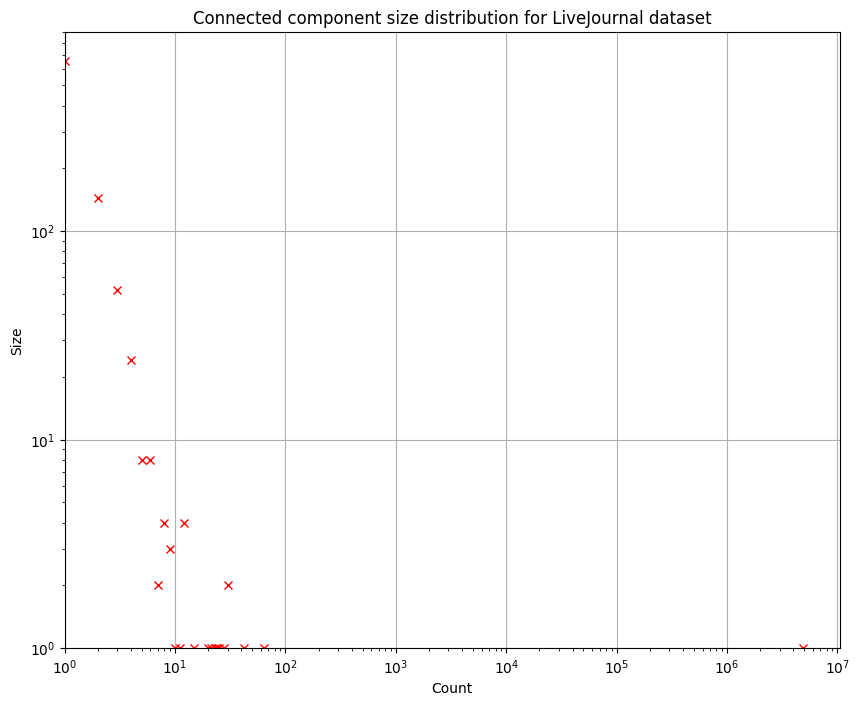

In [44]:
cc = result_livejournal.map(lambda x: (x[1], x[0])).groupByKey().mapValues(list)
cc = cc.map(lambda x: (len(x[1]), 1)) # key = CC size
cc = cc.reduceByKey(lambda x,y: x+y) # value = CC count
X = cc.map(lambda x: x[0]).collect()
Y = cc.map(lambda x: x[1]).collect()


plt.figure(figsize=(10,8))
plt.plot(X, Y, 'rx')

plt.xscale("log")
plt.xlabel("Count")
plt.xlim(left=1)  

plt.yscale("log")
plt.ylabel("Size")
plt.ylim(bottom=1)  

plt.title('Connected component size distribution for LiveJournal dataset')
plt.grid(True)

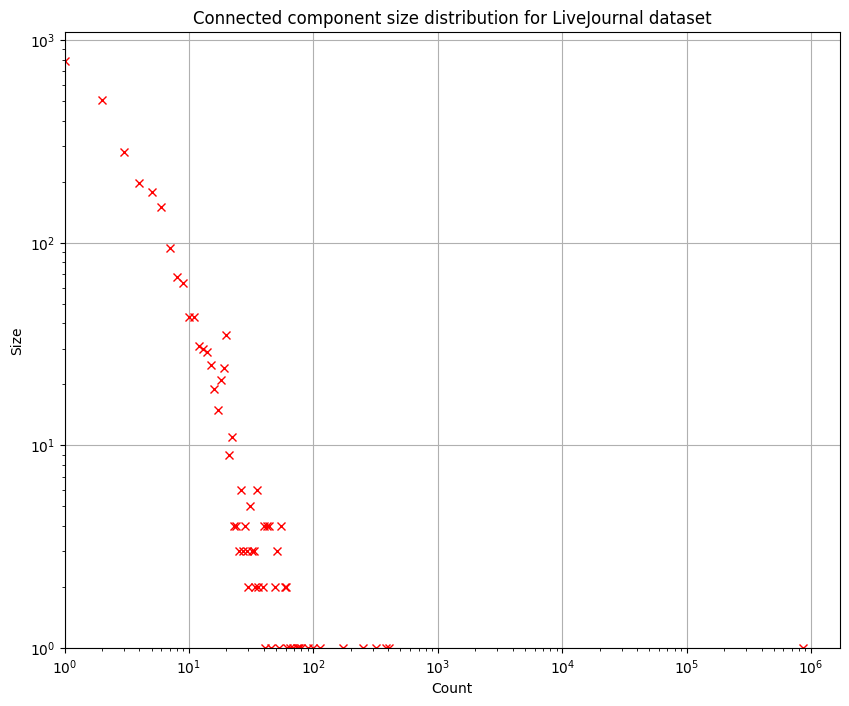

In [56]:
cc = result_google.map(lambda x: (x[1], x[0])).groupByKey().mapValues(list)
cc = cc.map(lambda x: (len(x[1]), 1)) # key = CC size
cc = cc.reduceByKey(lambda x,y: x+y) # value = CC count
X = cc.map(lambda x: x[0]).collect()
Y = cc.map(lambda x: x[1]).collect()


plt.figure(figsize=(10,8))
plt.plot(X, Y, 'rx')

plt.xscale("log")
plt.xlabel("Count")
plt.xlim(left=1)  

plt.yscale("log")
plt.ylabel("Size")
plt.ylim(bottom=1)  

plt.title('Connected component size distribution for LiveJournal dataset')
plt.grid(True)

In [48]:
sc.stop()